
*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'leandror@duff.(none)')


# Tópicos de 2017 utilizando TF-IDF / NMF - SToC

Esse notebook é a execução da modelagem de tópicos em cima dos titulos de artigos dos doutores da computação. Os artigos já estão pré-processados, separados em duas classes (No-spacy e com Spacy).
O algoritmo escolhe um número X final de tópicos, então geramos 3x  mais tópicos utilizando o NMF e então reduzimos utilizando o SToC para o número X. 
Calcular NPMI dos niveis de hierarquia do SToC e executar a similaridade com as áreas do ACM.

# Imports

In [2]:
import pandas as pd
import numpy as np
import unicodedata
import statistics
import operator

from fuzzywuzzy import fuzz 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.decomposition import NMF

from SToC import *

import os

from IPython.display import HTML, display
from tabulate import tabulate
from metrics import Evaluation as Eval

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

/home/leandro/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Opções de arranque

In [3]:
pd.set_option('display.max_colwidth',500)

# Funções

## Funções SToC

In [4]:
def print_join(iterates, model, W, n_topics, features, n_words):
	more = []
	tops = []

	more2 = []

	for i in range(len(iterates)):
		a = iterates[i][1]
		b = iterates[i][2]

		#mudar

		if ((a<n_topics)&(b>=n_topics)):
			aux = (model[a] + more[b-n_topics])/2
			#aux = more[b-n_topics]
			aux2 = (W[a] + more2[b-n_topics])/2
#
		if ((a>=n_topics)&(b<n_topics)):
			aux = (more[a-n_topics] + model[b])/2
			#aux = model[b]
			aux2 = (more2[a-n_topics] + W[b])/2

		if ((a>=n_topics)&(b>=n_topics)):
			#print a
			#print b
			#print len(more)
			aux = (more[a-n_topics] + more[b-n_topics])/2
			#aux = more[b-n_topics]# + more[b-n_topics])/2
			aux2 = (more2[a-n_topics] + more2[b-n_topics])/2
		
		if ((a < n_topics) & (b < n_topics)):
			aux = (model[a] + model[b])/2
			#aux = model[b]
			aux2 = (W[a] + W[b])/2

			
		#print aux
		more.append(aux)
		more2.append(aux2)
def print_estats(t2):

	valores = []
	for (i,j,k,l) in t2:
		valores.append(l)

	ex =  pd.Series(valores)
	print ("(Max+min)/2: ", (ex.max() + ex.min())/2)
	print ("Media: ", ex.mean())
	print( "Max: ", ex.max())
	print ("Min: ", ex.min())
	print ("Variancia: ", ex.var())
	print ("Desvio Padrao: ", ex.std())
	print ("Desvio Absoluto: ", ex.mad())
	return ex.mean()

def see_join(iterates, W, H, limiar,n_final):

    W = W.transpose()
    H = H.transpose()

    W_dict = {}
    H_dict = {}

    for i in range(len(W)):
        W_dict[i] = W[i]
    
    for i in range(len(H)):
        H_dict[i] = H[i]

	#iterates[i][0] numero do novo topicos
	#iterates[i][1] uniao tópico 1
	#iterates[i][2] uniao topico 2
	#iterates[i][3] valor (limiar)

 

	#iterates = sorted(iterates, key=lambda x: x[3], reverse=True)

	#print iterates
	#exit()
    n_topics = len(W)
    aux_final = len(W)
    print(aux_final)
    for idx,i in enumerate(range(len(iterates))):
        new = iterates[i][0]
        a = iterates[i][1]
        b = iterates[i][2]
        valor = iterates[i][3]
        
        #if valor < limiar:
        #	break

        if aux_final == n_final:
            break

        W_dict[new] = (W_dict[a] + W_dict[b])/2
        del(W_dict[a])
        del(W_dict[b])

        H_dict[new] = (H_dict[a] + H_dict[b])/2
        del(H_dict[a])
        del(H_dict[b])



        aux_final -=1

    W_new = []

    H_new = []

        #print (W_dict.keys())
        #exit()

        #print sorted(W_dict.keys())

    for i in sorted(W_dict.keys()):
        W_new.append(W_dict[i])

    for i in sorted(H_dict.keys()):
        H_new.append(H_dict[i])

    W_ret = np.zeros((len(W_new),len(W_new[0])))
    H_ret = np.zeros((len(H_new),len(H_new[0])))

    for i in range(len(W_new)):
        for j in range(len(W_new[0])):
            W_ret[i][j] = W_new[i][j]

    for i in range(len(H_new)):
        for j in range(len(H_new[0])):
            H_ret[i][j] = H_new[i][j]

    return W_ret,H_ret


In [40]:
import pickle
with open('../../datasets/'+ 'acm_hierachy' + '.pkl', 'rb') as f:
    acm = pickle.load(f)
with open('../../datasets/'+ 'acm_areas' + '.pkl', 'rb') as f:
    areas = pickle.load(f)
with open('../../datasets/'+ 'acm_areas_id' + '.pkl', 'rb') as f:
    areas_id = pickle.load(f)
with open('../../datasets/'+ 'acm_areas_parents' + '.pkl', 'rb') as f:
    areas_parents = pickle.load(f)

## Função de visualização

In [6]:
def print_top_words_display(H, feature_names, n_top_words):
    table_output = [['Topic','topwords']]
    topics = []
    for topic_idx, topic in enumerate(H):
        top_index = ["Topic # %d" % topic_idx]
        top_words = [" ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])]
        values = [value for value in np.sort(topic)[:-n_top_words - 1:-1]]
        table_output.append(top_index + top_words)
        topics.append(" ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
    df_out = pd.DataFrame(table_output, index=None)
    display(HTML(tabulate(table_output, tablefmt='html')))
    return topics,df_out

## TF-IDF

In [7]:
def execute_tfidf(dataset,max_df=1,min_df=1,ngram=(0,2),stop_words=[]):
    tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df,ngram_range=ngram,stop_words=stop_words)
    tfidf = tfidf_vectorizer.fit_transform(dataset)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    return tfidf,tfidf_feature_names

## NMF

In [8]:
def execute_nmf(tfidf,n_topics = 10,n_components = 5):
    n_topics = n_topics
    n_components = n_components
    nmf = NMF(n_components=n_components,max_iter=400)
    W = nmf.fit_transform(tfidf)
    H = nmf.components_.transpose() 
    return nmf,W,H

## SToC

In [9]:
def execute_stoc(W,H,n_final,n_components):
    n_words = H.shape[0]

    topXtop_norm = getIrredutibleMatrix(W,H,n_components)
    assign, t2 = joinTopics(n_components, topXtop_norm)


    tops = print_join(t2, H.transpose(), W, n_components, None, n_words)

    limiar = print_estats(t2)

    W_new, H_new = see_join(t2, W, H, limiar,n_final)
    return W_new,H_new

# Carregar artigos do ano de 2017

In [10]:
ano = str(2017)
df_artigos = pd.read_csv('../../datasets/artigos/preprocessed/without_spacy/artigos2017_pre',sep="|",index_col=0)
#df_artigos = pd.read_csv('datasets/trabalhosPre.txt',sep="|",index_col=0)
artigos = df_artigos['titulo'].values

In [11]:
valor = 0
for i in df_artigos['titulo']:
    valor +=len(set(i.split()))
print("Densidade: {0}".format(valor/len(df_artigos)))

Densidade: 7.071221532091097


# Remoção das palavras de acordo com sua frequência

In [12]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(artigos)
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#print(words_freq)
indices = np.arange(len(words_freq))

## Histograma das frequências das palavras

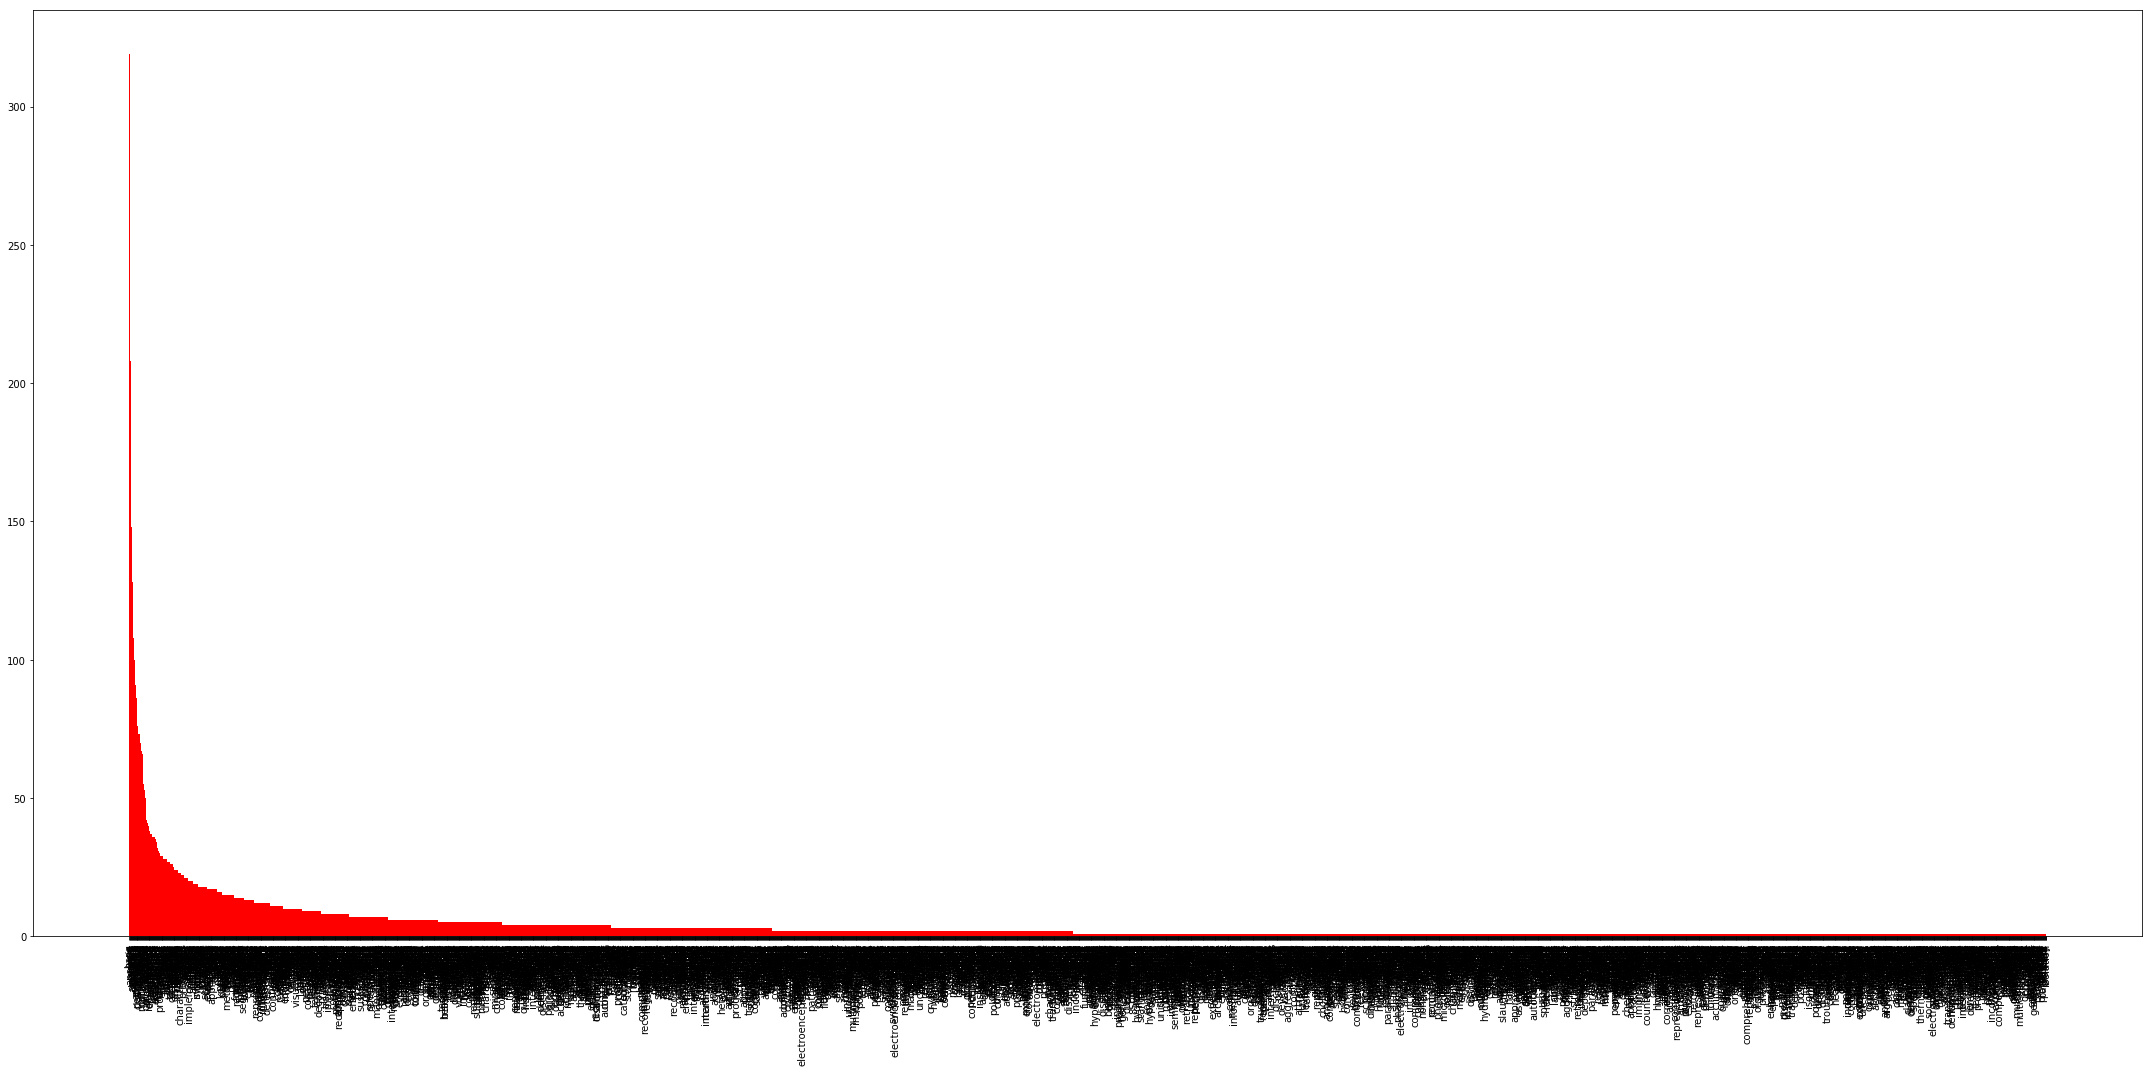

In [13]:
%matplotlib inline

word = []
frequency = []
for i in range(len(words_freq)):
    word.append(words_freq[i][0])
    frequency.append(words_freq[i][1])
plt.figure(figsize=(30, 15))
plt.bar(indices,frequency,width =1, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()


## Remoção das palavras com frequência igual ou menor que 10 e maior ou igual a 100

In [33]:
# new_stop_words = []
# word = []
# frequency = []
# indices = 0
# for words in words_freq:
#     if words[1] <= -1 or words[1] >= 0:
#         new_stop_words.append(words[0])
#         word.append(words[0])
#     elif words[0].isdigit():
#         new_stop_words.append(words[0])
#         word.append(words[0])
#     else:
#         frequency.append(words[1])
#         indices +=1
# plt.figure(figsize=(30, 15))
# plt.bar(range(indices),frequency,width =1, color='r')
# #plt.xticks(range(indices), word, rotation='vertical')
# plt.tight_layout()
# plt.show()
# new_stop_words.append('datum')
    

In [35]:
print(len(words_freq))
#print(len(new_stop_words))

3989


In [14]:
f = open('../acm_words.txt','r')
acm_words = f.read().replace('\n',' ').split()

## (teste) Retirar todas palavras que não pertencem ao grupo de palavras das áreas da ACM

In [15]:
stop_words_without_acm_words = list(set(word) - set(acm_words))

In [ ]:
len(set(word).intersection(acm_words))

In [ ]:
len(word)

In [ ]:
len(acm_words)

In [ ]:
len(stop_words_without_acm_words)

# Parametros do TF-IDF e SToC

In [16]:
# TF-IDF
max_df = 0.85
min_df = 0.01
ngram= (1,1)
#NMF
n_components = 60
n_topics = 10
# STOC
#n_final = 30

# Gerar tópicos e hierarquia do SToC

## Executando TF-IDF

In [17]:
tfidf,tfidf_feature_names = execute_tfidf(artigos,max_df=max_df,min_df=min_df,ngram=ngram,stop_words = stop_words_without_acm_words)

## Executando NMF

In [18]:
nmf,W,H = execute_nmf(n_components=n_components,n_topics=n_topics,tfidf=tfidf)

# Visualização dos Tópicos gerados pelo NMF

In [19]:
topics_nmf,a = print_top_words_display(H.transpose(), tfidf_feature_names,n_topics)

Topic,topwords
Topic # 0,base selection cloud product networks heuristic identification engineering environment estimation
Topic # 1,use neural prediction computer education mining search computing sensor environment
Topic # 2,analysis computer computing quality sensor software feature networks environment base
Topic # 3,model computing mining prediction wireless search solution network health graph
Topic # 4,network neural service sensor education computing search feature prediction engineering
Topic # 5,system wireless literature product algorithms engineering neural test framework environment
Topic # 6,algorithm selection cloud computer networks search product machine service game
Topic # 7,software product literature service level engineering search networks assessment environment
Topic # 8,time prediction service wireless cloud quality mapping process learning multi
Topic # 9,evaluation algorithms quality wireless computing service engineering feature software game


In [20]:
import pickle
with open('topicos.pickle', 'wb') as handle:
    pickle.dump(W, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Áreas da ACM similares com as palavras do tópico

- Além de mostrar as áreas, tambem mostra a hierarquia da área similar ao tópico

In [30]:
table = []
for idx,topic in enumerate(topics_nmf):
    similar_area = topic_acm_area(topic,areas_id,areas_parents)
    print("---------------------------------------")
    print("\n")
    if similar_area.items():
        maior = 0
        for value in similar_area:
#             if not len(areas_parents[value]) == 0:
            if similar_area[value] > maior:
                maior = similar_area[value]
        for i in getKeysByValue(similar_area,maior):
            if len(areas_parents[i]) == 0:
                result = areas_id[i]
            
        print(result)
        table.append([idx,topic,result])

base selection cloud product networks heuristic identification engineering environment estimation
---------------------------------------


networks
use neural prediction computer education mining search computing sensor environment
---------------------------------------


social and professional topics
analysis computer computing quality sensor software feature networks environment base
---------------------------------------


software and its engineering
model computing mining prediction wireless search solution network health graph
---------------------------------------


networks
network neural service sensor education computing search feature prediction engineering
---------------------------------------


networks
system wireless literature product algorithms engineering neural test framework environment
---------------------------------------


computing methodologies
algorithm selection cloud computer networks search product machine service game
-----------------------------

---------------------------------------


social and professional topics
game literature education quality neural algorithms feature programming mapping location
---------------------------------------


theory of computation
multi selection heuristic assessment engineering algorithms software recognition location architecture
---------------------------------------


software and its engineering
algorithms mining prediction education service selection quality analysis engineering environment
---------------------------------------


computing methodologies
generation heuristic solution wireless networks algorithms network mapping energy classification
---------------------------------------


networks


In [ ]:
maior = 0
for value in similar_area:
    if areas_parents[value]:
        if similar_area[value] > maior:
            maior = similar_area[value]
[areas_id[i] for i in getKeysByValue(similar_area,maior)]

In [ ]:
pd.DataFrame(table,columns=['id','topwords','description'])

In [37]:
aux = []
for i in (set([row[2] for row in table])):
    aux2 = []
    for t in table:
        if t[2] == i:
            aux2.append(t[0])
    aux.append([i,aux2])

In [38]:
idx = getKeysByValue(areas_id,'computing methodologies')
y = []
for i in areas_parents:
    value = areas_parents[i]
    if idx[0] in value:
        if len(value) == 1: # Hieirarquias
            y.append(i)
m = 0
for area in [areas_id[j] for j in y]:
    a = fuzz.partial_token_set_ratio(area,topic)
    #print(a)
    if a > m:
        m = a

    if a >= 44:
         print(area)

machine learning
distributed computing methodologies


In [33]:
with open('document_dict.pickle', 'wb') as handle:
    pickle.dump(document_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
document_dict  = {}
for a in aux:
    print(a[1])
    for i in a[1]:
        vec = []
        for idx,value in enumerate(W.transpose()[i]):
            if value > 0:
                vec.append(idx)
        document_dict[a[0]] = vec

[5, 11, 22, 26, 35, 40, 43, 50, 56, 58]
[1, 10, 17, 20, 28, 32, 33, 42, 44, 48, 49]
[0, 3, 4, 6, 12, 16, 19, 21, 24, 25, 27, 30, 38, 47, 51, 52, 55, 57]
[15, 54]
[2, 7, 8, 9, 18, 23, 29, 36, 37, 39, 41, 46, 53]
[34, 45]
[13, 14, 31, 59]


In [41]:
table_new = []
for a in aux:
    #print(a[0])
    for t in  a[1]:
        to = table[t][1]
        y = []
        idx = getKeysByValue(areas_id,table[t][2])
        for i in areas_parents:
            value = areas_parents[i]
            if idx[0] in value:
                if len(value) == 1: # Hieirarquias
                    y.append(i)
        m = 0
        for area in [areas_id[j] for j in y]:
            #print(area)
            a = fuzz.partial_token_set_ratio(area,to)
            #print(a)
            if a > m:
                m = a
                s = area
        table_new.append([s,W.transpose()[table[t][0]],table[t][0]])

In [55]:
aux = []
for i in (set([row[0] for row in table_new])):
    aux2 = []
    cont = 0
    for idx,t in enumerate(table_new):
        if t[0] == i:
            cont+=1
            vec1 = t[1]
            if idx > 0:
                vec1 += t[1]
    vec1 = vec1/cont
    aux.append([i,vec1])

In [56]:
print(aux)

[['very large scale integration design', array([0., 0., 0., ..., 0., 0., 0.])], ['network algorithms', array([0., 0., 0., ..., 0., 0., 0.])], ['electronic design automation', array([0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.000196])], ['network protocols', array([0.       , 0.       , 0.       , ..., 0.       , 0.       ,
       0.0109494])], ['computing   technology policy', array([0., 0., 0., ..., 0., 0., 0.])], ['design and analysis of algorithms', array([0., 0., 0., ..., 0., 0., 0.])], ['user characteristics', array([0., 0., 0., ..., 0., 0., 0.])], ['computer graphics', array([0., 0., 0., ..., 0., 0., 0.])], ['software creation and management', array([0., 0., 0., ..., 0., 0., 0.])], ['network performance evaluation', array([0.       , 1.4673808, 0.       , ..., 0.       , 0.       ,
       0.       ])], ['modeling and simulation', array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.00363064])], ['information storage systems', array([0., 0

## Métricas TFIDF Coherence e avaliando tópicos utilizando o NPMI 

In [49]:
def tf_idf_print(tfidf_coherence):
    print("TF-IDF Coherence Score")
    print("----------------------")
    print("Média: {}".format(statistics.mean(tfidf_coherence)))
    print("Desvio Padrão: {}".format(statistics.stdev(tfidf_coherence)))
    print("Variância: {}".format(statistics.variance(tfidf_coherence)))
    print("Min: {}".format(min(tfidf_coherence)))
    print("Max: {}".format(max(tfidf_coherence)))
    print("----------------------")
    print("")
def pmi_npmi_print(pmi,npmi):
    print("PMI e NPMI Score")
    print("----------------------")
    print("Média: PMI -> {}, NPMI -> {}".format(statistics.mean(pmi),statistics.mean(npmi)))
    print("Desvio Padrão: PMI -> {}, NPMI -> {}".format(statistics.stdev(pmi),statistics.stdev(npmi)))
    print("Variância: PMI -> {}, NPMI -> {}".format(statistics.variance(pmi),statistics.variance(npmi)))
    print("Min: PMI -> {}, NPMI -> {}".format(min(pmi),min(npmi)))
    print("Max: PMI -> {}, NPMI -> {}".format(max(pmi),max(npmi)))
    print("----------------------")

In [ ]:
n_terms, words, word_frequency, term_docs = Eval.count(artigos)
tfidf_coherence = Eval.tfidf_coherence(topics_nmf, tfidf, tfidf_feature_names)
pmi, npmi = Eval.pmi(topics_nmf, word_frequency, term_docs,len(artigos), 10)

In [ ]:
tf_idf_print(tfidf_coherence)
pmi_npmi_print(pmi,npmi)

## Executando SToC mostrando cada iteraçao do algoritmo

In [ ]:
print(H.shape,H_new.transpose().shape)

### Funções para achar similaridade entre os tópicos e as áreas da ACM

In [22]:
def area_parents(area,areas_id,areas_parents,similar_area):
    li_id = getKeysByValue(areas_id,area)
    parents = [areas_parents[i] for i in li_id]
    for li in li_id:
        if li not in similar_area.keys():
            similar_area[li] = 1
        else:
            similar_area[li] += 1
    for parent in parents:
        for p in parent:
            if p not in similar_area.keys():
                similar_area[p] =1
            else:
                similar_area[p] +=1
                
        #print(area+"-->"+"-->".join([areas_id[i] for i in parent][::-1]))
    return similar_area

In [23]:
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return  listOfKeys

In [24]:
def topic_acm_area(topic,areas_id,areas_parents):
    similar_area = {}
    print(topic)
    m = 0
    for area in list(set(areas_id.values())):
        a = fuzz.partial_token_set_ratio(area,topic)
        if a > m:
            m = a

        if a >= 70:
             area_parents(area,areas_id,areas_parents,similar_area)
    return similar_area

### Executando SToC, cada execução diminuindo cinco tópicos

In [46]:
n_components_new = n_components
H_new = H
W_new = W
for level in [i for i in range(0,n_components,10)][::-1]:
    W_new,H_new = execute_stoc(H=H_new,W=W_new,n_components=n_components_new,n_final=level)
    topics, df_out = print_top_words_display(H_new, tfidf_feature_names,n_topics)
    #pmi, nmpi = Eval.pmi(topics, word_frequency, term_docs,len(artigos), 10)
    n_components_new = level
    H_new = H_new.transpose()
    W_new = W_new.transpose()
    #pmi, nmpi = Eval.pmi(topics, word_frequency, term_docs,len(artigos), 10)
    #pmi_npmi_print(pmi,npmi)
#     for topic in topics:
#         print(topic)
#         topic_acm_area(topic,areas_id,areas_parents)
#         print("---------------------------------------")
#         print("\n")
    table = []
    for idx,topic in enumerate(topics):
        similar_area = topic_acm_area(topic,areas_id,areas_parents)
        print("---------------------------------------")
        print("\n")
        if similar_area.items():
            maior = 0
            for value in similar_area:
                if not len(areas_parents[value]) == 0:
                    if similar_area[value] > maior:
                        maior = similar_area[value]
            result = []
            for i in getKeysByValue(similar_area,maior):
                if len(areas_parents[i]) != 0:
                    result.append(areas_id[i])

            print(result)
            table.append([idx,topic,result])
    df_table = pd.DataFrame(table,columns=['id','topwords','description'])
    df_table.to_csv('topic_hier'+str(level)+'.csv',index=False)

('NumTopics: ', 1)
(Max+min)/2:  51.55853912958803
Media:  58.97745202204613
Max:  101.25689156435882
Min:  1.8601866948172303
Variancia:  798.2330369168096
Desvio Padrao:  28.253018191280194
Desvio Absoluto:  24.245044834642208
60


/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:77: RuntimeWarning: invalid value encountered in double_scalars
  minConn = (1 - restartProbability) * 1/(n_topics-1)
/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:107: RuntimeWarning: invalid value encountered in double_scalars
  minConn = (1 - restartProbability) * 1/(k-1)
/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:482: RuntimeWarning: invalid value encountered in double_scalars
  minProbability = leavingProbability * 1/(meanNumLinks)


Topic,topwords
Topic # 0,base selection product generation networks heuristic wireless engineering environment estimation
Topic # 1,use neural research prediction mining education computer literature generation search
Topic # 2,analysis health computer solution research feature software networks environment sensor
Topic # 3,model mining prediction wireless engineering generation search level computing network
Topic # 4,network neural service sensor search feature computer environment estimation evaluation
Topic # 5,system health literature wireless engineering solution product algorithms neural test
Topic # 6,algorithm selection computer search networks product machine game recognition structure
Topic # 7,time solution service prediction wireless game activity support assessment multi
Topic # 8,evaluation algorithms wireless service engineering game technology feature computing software
Topic # 9,data mining service literature heuristic health sensor feature environment estimation


base selection product generation networks heuristic wireless engineering environment estimation
---------------------------------------


['network properties', 'network types']
use neural research prediction mining education computer literature generation search
---------------------------------------


['information retrieval']
analysis health computer solution research feature software networks environment sensor
---------------------------------------


['software creation and management']
model mining prediction wireless engineering generation search level computing network
---------------------------------------


['professional topics']
network neural service sensor search feature computer environment estimation evaluation
---------------------------------------


['information retrieval']
system health literature wireless engineering solution product algorithms neural test
---------------------------------------


['design and analysis of algorithms']
algorithm selection compu

---------------------------------------


['mathematical optimization']
('NumTopics: ', 1)
(Max+min)/2:  47.69969624346666
Media:  52.38927860624614
Max:  93.4694633545266
Min:  1.9299291324067214
Variancia:  756.3303330225207
Desvio Padrao:  27.50146056162328
Desvio Absoluto:  24.65285697379886
50


/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:77: RuntimeWarning: invalid value encountered in double_scalars
  minConn = (1 - restartProbability) * 1/(n_topics-1)
/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:107: RuntimeWarning: invalid value encountered in double_scalars
  minConn = (1 - restartProbability) * 1/(k-1)
/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:482: RuntimeWarning: invalid value encountered in double_scalars
  minProbability = leavingProbability * 1/(meanNumLinks)


Topic,topwords
Topic # 0,use neural research prediction mining education computer literature generation search
Topic # 1,analysis health computer solution research feature software networks environment sensor
Topic # 2,model mining prediction wireless engineering generation search level computing network
Topic # 3,network neural service sensor search feature computer environment estimation evaluation
Topic # 4,system health literature wireless engineering solution product algorithms neural test
Topic # 5,algorithm selection computer search networks product machine game recognition structure
Topic # 6,time solution service prediction wireless game activity support assessment multi
Topic # 7,evaluation algorithms wireless service engineering game technology feature computing software
Topic # 8,data mining service literature heuristic health sensor feature environment estimation
Topic # 9,application computer product solution sensor service algorithms classification test environment


use neural research prediction mining education computer literature generation search
---------------------------------------


['information retrieval']
analysis health computer solution research feature software networks environment sensor
---------------------------------------


['software creation and management']
model mining prediction wireless engineering generation search level computing network
---------------------------------------


['professional topics']
network neural service sensor search feature computer environment estimation evaluation
---------------------------------------


['information retrieval']
system health literature wireless engineering solution product algorithms neural test
---------------------------------------


['design and analysis of algorithms']
algorithm selection computer search networks product machine game recognition structure
---------------------------------------


['network types']
time solution service prediction wireless game activity 

/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:77: RuntimeWarning: divide by zero encountered in double_scalars
  minConn = (1 - restartProbability) * 1/(n_topics-1)
/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  minConn = (1 - restartProbability) * 1/(k-1)
/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:482: RuntimeWarning: divide by zero encountered in double_scalars
  minProbability = leavingProbability * 1/(meanNumLinks)


Topic,topwords
Topic # 0,analysis health computer solution research feature software networks environment sensor
Topic # 1,model mining prediction wireless engineering generation search level computing network
Topic # 2,network neural service sensor search feature computer environment estimation evaluation
Topic # 3,algorithm selection computer search networks product machine game recognition structure
Topic # 4,time solution service prediction wireless game activity support assessment multi
Topic # 5,data mining service literature heuristic health sensor feature environment estimation
Topic # 6,optimization algorithms selection wireless search engineering product programming generation level
Topic # 7,control literature prediction product solution health level sensor network estimation
Topic # 8,process literature mining engineering selection solution research service programming recognition
Topic # 9,framework selection search education wireless generation networks computing activity quality


analysis health computer solution research feature software networks environment sensor
---------------------------------------


['software creation and management']
model mining prediction wireless engineering generation search level computing network
---------------------------------------


['professional topics']
network neural service sensor search feature computer environment estimation evaluation
---------------------------------------


['information retrieval']
algorithm selection computer search networks product machine game recognition structure
---------------------------------------


['network types']
time solution service prediction wireless game activity support assessment multi
---------------------------------------


['theory and algorithms for application domains']
data mining service literature heuristic health sensor feature environment estimation
---------------------------------------


['data management systems']
optimization algorithms selection wireless sear

/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:77: RuntimeWarning: invalid value encountered in double_scalars
  minConn = (1 - restartProbability) * 1/(n_topics-1)
/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:107: RuntimeWarning: invalid value encountered in double_scalars
  minConn = (1 - restartProbability) * 1/(k-1)
/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:482: RuntimeWarning: invalid value encountered in double_scalars
  minProbability = leavingProbability * 1/(meanNumLinks)


Topic,topwords
Topic # 0,analysis health computer solution research feature software networks environment sensor
Topic # 1,model mining prediction wireless engineering generation search level computing network
Topic # 2,network neural service sensor search feature computer environment estimation evaluation
Topic # 3,time solution service prediction wireless game activity support assessment multi
Topic # 4,optimization algorithms selection wireless search engineering product programming generation level
Topic # 5,control literature prediction product solution health level sensor network estimation
Topic # 6,graph solution neural game structure learning power detection model algorithm
Topic # 7,estimation selection neural search generation quality software architecture application data
Topic # 8,test heuristic generation machine assessment computing software application programming impact
Topic # 9,simulation engineering wireless software computing mapping assessment architecture network environment


analysis health computer solution research feature software networks environment sensor
---------------------------------------


['software creation and management']
model mining prediction wireless engineering generation search level computing network
---------------------------------------


['professional topics']
network neural service sensor search feature computer environment estimation evaluation
---------------------------------------


['information retrieval']
time solution service prediction wireless game activity support assessment multi
---------------------------------------


['theory and algorithms for application domains']
optimization algorithms selection wireless search engineering product programming generation level
---------------------------------------


['design and analysis of algorithms']
control literature prediction product solution health level sensor network estimation
---------------------------------------


['network properties']
graph solution neural

/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:77: RuntimeWarning: invalid value encountered in double_scalars
  minConn = (1 - restartProbability) * 1/(n_topics-1)
/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:107: RuntimeWarning: invalid value encountered in double_scalars
  minConn = (1 - restartProbability) * 1/(k-1)
/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:482: RuntimeWarning: invalid value encountered in double_scalars
  minProbability = leavingProbability * 1/(meanNumLinks)


Topic,topwords
Topic # 0,base management recognition quality search environment energy architecture heuristic identification
Topic # 1,detection image power system use support classification learning multi systems
Topic # 2,modeling process design performance evaluation application mining solution literature computer
Topic # 3,location optimization algorithm service selection algorithms search engineering wireless feature
Topic # 4,impact framework information data selection education mining health service solution
Topic # 5,control time prediction solution service literature product health wireless level
Topic # 6,estimation model selection neural search generation mining prediction wireless engineering
Topic # 7,test analysis heuristic health computer generation machine solution assessment research
Topic # 8,network structure activity neural prediction research service health mining sensor
Topic # 9,simulation graph solution neural engineering wireless software computing mapping game


base management recognition quality search environment energy architecture heuristic identification
---------------------------------------


['information retrieval']
detection image power system use support classification learning multi systems
---------------------------------------


['machine learning']
modeling process design performance evaluation application mining solution literature computer
---------------------------------------


['interaction design']
location optimization algorithm service selection algorithms search engineering wireless feature
---------------------------------------


['design and analysis of algorithms']
impact framework information data selection education mining health service solution
---------------------------------------


['data management systems']
control time prediction solution service literature product health wireless level
---------------------------------------


['software notations and tools']
estimation model selection neural search 

/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:77: RuntimeWarning: invalid value encountered in double_scalars
  minConn = (1 - restartProbability) * 1/(n_topics-1)
/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:107: RuntimeWarning: invalid value encountered in double_scalars
  minConn = (1 - restartProbability) * 1/(k-1)
/home/leandror/Dissertação/dissertacao/testes/nmf_stoc/SToC.py:482: RuntimeWarning: invalid value encountered in double_scalars
  minProbability = leavingProbability * 1/(meanNumLinks)


Topic,topwords
Topic # 0,location optimization control time algorithm test estimation network analysis model


location optimization control time algorithm test estimation network analysis model
---------------------------------------


['mathematical optimization']


In [ ]:
df_out = print_top_words_display(H_new, tfidf_feature_names,n_topics)
# df_out.to_csv('topics_'+ano+'.csv',header=None)

In [ ]:
n_terms, words, word_frequency, term_docs = Eval.count(artigos)

In [ ]:
Eval.tfidf_coherence(topics, tfidf, tfidf_feature_names)

In [ ]:
pmi, nmpi = Eval.pmi(topics, word_frequency, term_docs,len(artigos), 10)

In [119]:
x = []
for value in W.transpose():
    x.append(len([v for v in value if v > 0 ]))
tf_idf_print(x)

TF-IDF Coherence Score
----------------------
Média: 202.31666666666666
Desvio Padrão: 64.12659398796396
Variância: 4112.220056497175
Min: 100
Max: 420
----------------------



In [122]:
x = []
for value in W.transpose():
    x.append(len([v if not in x else -1 for v in value ])

SyntaxError: invalid syntax (<ipython-input-122-515c4d223780>, line 3)

In [123]:
word_freq_dict = dict(words_freq)
media_freq = 0
for word in tfidf_feature_names:
    media_freq += word_freq_dict[word]
media_freq = media_freq/len(tfidf_feature_names)
print(media_freq/len(artigos))

0.024486598399641877
